# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
import numpy as np

from collections import deque
import time
import torch

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Initialize the agent

In [5]:
from ddpg_agent import Agent
# Initialize the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=1)

### 4. DDPG learning

In [6]:
def ddpg(n_episodes=2000, max_t=1500, print_interval=10, update_every=5, num_update=10, goal_score=0.5):
    scores_deque = deque(maxlen=100)
    scores_all = []
    
    for i_episode in range(1, n_episodes+1):
        # Reset Env and Agent
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment    
        states = env_info.vector_observations                   # get the current state (for each agent)
        scores = np.zeros(num_agents)                            # initialize the score (for each agent)
        agent.reset()
        
        # Record the start time of one episode
        start_time = time.time()
        for t in range(max_t):
            # Take the actions based on the actor network of the agent
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            dones = env_info.local_done                         # see if episode finished
            
            # send the state-action-reward pair to the agent
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done) 
            
            scores += env_info.rewards                           # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            
            # Update the network regularly
            if t%update_every == 0:
                for _ in range(num_update):
                    agent.start_learn()
            # exit loop if episode finished
            if np.any(dones):                                   
                break
    
        max_score = np.max(scores)
        
        scores_deque.append(max_score)
        scores_all.append(max_score)
        average_score = np.mean(scores_deque)
        duration = time.time() - start_time
        
        if i_episode % print_interval == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tMean within episode: {:.2f}\tTrain Time: {:.2f}'
                  .format(i_episode, average_score, max_score, duration))
        if average_score >= goal_score and i_episode >= 100:
            print('Problem Solved after {} epsisodes!! Average score: {:.2f}'.format(i_episode, average_score))
            torch.save(agent.actorNet_local.state_dict(), 'actor_net.pth')
            torch.save(agent.criticNet_local.state_dict(), 'critic_net.pth')
            break
    
    return scores_all

scores = ddpg()

Episode 10	Average Score: 0.00	Mean within episode: 0.00	Train Time: 0.06
Episode 20	Average Score: 0.00	Mean within episode: 0.00	Train Time: 0.63
Episode 30	Average Score: 0.00	Mean within episode: 0.00	Train Time: 0.65
Episode 40	Average Score: 0.00	Mean within episode: 0.00	Train Time: 0.64
Episode 50	Average Score: 0.01	Mean within episode: 0.10	Train Time: 1.51
Episode 60	Average Score: 0.01	Mean within episode: 0.09	Train Time: 1.29
Episode 70	Average Score: 0.01	Mean within episode: 0.00	Train Time: 0.63
Episode 80	Average Score: 0.02	Mean within episode: 0.10	Train Time: 1.50
Episode 90	Average Score: 0.02	Mean within episode: 0.00	Train Time: 0.64
Episode 100	Average Score: 0.02	Mean within episode: 0.09	Train Time: 1.33
Episode 110	Average Score: 0.03	Mean within episode: 0.10	Train Time: 1.51
Episode 120	Average Score: 0.04	Mean within episode: 0.00	Train Time: 0.63
Episode 130	Average Score: 0.05	Mean within episode: 0.10	Train Time: 1.30
Episode 140	Average Score: 0.06	Me

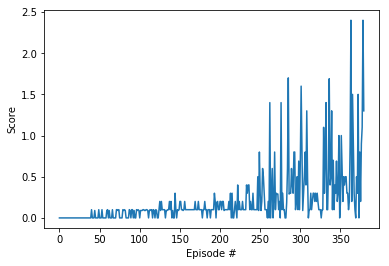

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
#fig.savefig('score_vs_episode.jpg',dpi = 300)
#plt.close()